# Interface between two material

Authors: O. Castany, C. Molinaro, M. Müller

Interface between two materials n1/n2. Calculations of the transmission and reflexion coefficients with varying incidence angle.

In [1]:
import numpy as np
import elli
from scipy.constants import c, pi
import matplotlib.pyplot as plt

## Structure definition

In [2]:
# Materials
n1 = 1
n2 = 1.5
front = elli.IsotropicMaterial(elli.ConstantRefractiveIndex(n1))
back = elli.IsotropicMaterial(elli.ConstantRefractiveIndex(n2))

# Structure
s = elli.Structure(front, [], back)

# Parameters for the calculation
lbda = 1000
k0 = 2*pi/lbda
Phi_list = np.linspace(0, 89, 90)  #  range for the incidence angles

## Analytical calculation

In [3]:
Phi_i = np.deg2rad(Phi_list)

Phi_t = np.arcsin((n1*np.sin(Phi_i)/n2).astype(complex))
kz1 = n1*k0*np.cos(Phi_i)
kz2 = n2*k0*np.cos(Phi_t)
r_s = (kz1 - kz2) / (kz1 + kz2)
t_s = 1 + r_s
r_p = (kz1 * n2**2 - kz2 * n1**2) / (kz1 * n2**2 + kz2 * n1**2)
t_p = np.cos(Phi_i)*(1-r_p)/np.cos(Phi_t)

# Reflection and transmission coefficients, polarisation s and p
R_th_ss = abs(r_s)**2
R_th_pp = abs(r_p)**2
t2_th_ss = abs(t_s)**2
t2_th_pp = abs(t_p)**2
# The power transmission coefficient is T = Re(kz2/kz1) × |t|^2
correction = np.real(kz2/kz1)
T_th_ss = correction * t2_th_ss
T_th_pp = correction * t2_th_pp

## Calculation with Berreman4x4

In [4]:
data = elli.ResultList([s.evaluate(lbda, Phi_i) for Phi_i in Phi_list])
    
R_pp = data.R_pp
R_ss = data.R_ss

T_pp = data.T_pp
T_ss = data.T_ss

t2_pp = np.abs(data.t_pp)**2
t2_ss = np.abs(data.t_ss)**2

## Plotting

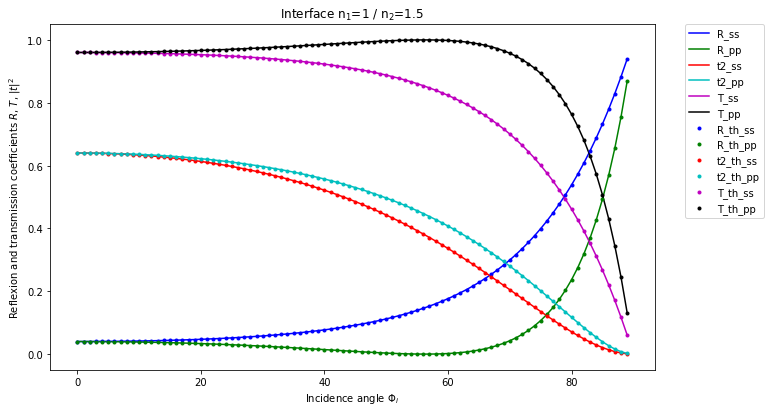

In [5]:
fig = plt.figure(figsize=(12., 6.))
plt.rcParams['axes.prop_cycle'] = plt.cycler('color', 'bgrcmk')
ax = fig.add_axes([0.1, 0.1, 0.7, 0.8])

d = np.vstack((R_ss, R_pp, t2_ss, t2_pp, T_ss, T_pp)).T
lines1 = ax.plot(Phi_list, d)
legend1 = ("R_ss", "R_pp", "t2_ss", "t2_pp", "T_ss", "T_pp")

d = np.vstack((R_th_ss, R_th_pp, t2_th_ss, t2_th_pp, T_th_ss, T_th_pp)).T
lines2 = ax.plot(Phi_list, d, '.')
legend2 = ("R_th_ss", "R_th_pp", "t2_th_ss", "t2_th_pp", "T_th_ss", "T_th_pp")

ax.legend(lines1 + lines2, legend1 + legend2,
          loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)

ax.set_title("Interface n$_1$={:} / n$_2$={:}".format(n1, n2))
ax.set_xlabel(r"Incidence angle $\Phi_i$ ")
ax.set_ylabel(r"Reflexion and transmission coefficients $R$, $T$, $|t|^2$")

plt.show()